In [ ]:
!pip install tensorflow keras scikit-learn opencv-python  tensorflow-datasets

## data preprocess

In [ ]:
import cv2
import numpy as np
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, PReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint  # Import ModelCheckpoint

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.4, color=False)
x, y = lfw_people.images, lfw_people.target
target_names = lfw_people.target_names

# Preprocess images by resizing to 112x112
def preprocess_images(images, img_size=112):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (img_size, img_size))
        resized_images.append(resized_img)
    resized_images = np.array(resized_images)
    resized_images = resized_images.reshape(-1, img_size, img_size, 1) / 255.0  # Normalize
    return resized_images

x_processed = preprocess_images(x)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=42)

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

num_classes = y_train_onehot.shape[1]

# MobileFaceNet from scratch

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,  Dropout, PReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Flatten, Add

def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    return PReLU(shared_axes=[1, 2])(x)

def depthwise_conv_block(x, filters, strides=1):
    x = DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = PReLU(shared_axes=[1, 2])(x)

    x = Conv2D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return PReLU(shared_axes=[1, 2])(x)

def mobilefacenet(input_shape=(112, 112, 1), embedding_size=256):
    input_layer = Input(shape=input_shape)

    # Initial Conv Layer
    x = conv_block(input_layer, 64, 3, strides=2)

    # Depthwise Separable Convolution Layers
    x = depthwise_conv_block(x, 64, strides=1)
    x = depthwise_conv_block(x, 128, strides=2)
    x = depthwise_conv_block(x, 128, strides=2)
    x = Dropout(0.5)(x)
    x = depthwise_conv_block(x, 128, strides=1)
    x = depthwise_conv_block(x, 256, strides=2)
    x = depthwise_conv_block(x, 256, strides=1)

    # Global Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(embedding_size)(x)

    # Output Layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)

model = mobilefacenet(input_shape=(112, 112, 1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 112, 112, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu (PReLU)                      │ (None, 56, 56, 64)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_1 (PReLU)                    │ (None, 56, 56, 64)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 56, 56, 64)          │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_2 (PReLU)                    │ (None, 56, 56, 64)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 28, 28, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_3 (PReLU)                    │ (None, 28, 28, 64)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu_4 (PReLU)                    │ (None, 28, 28, 128)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 14, 14, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 234,338 (915.38 KB)

 Trainable params: 230,754 (901.38 KB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add checkpoints to save the best model
# Add checkpoints to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_mobilefacenet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train model
history = model.fit(x_train, y_train_onehot, validation_data=(x_test, y_test_onehot), epochs=70, batch_size=16,callbacks=[checkpoint])


In [ ]:
# Load the best model for real-time recognition
model = load_model('best_mobilefacenet_model.keras')
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Save your trained model
model.save('best_mobilefacenet_model.h5')


In [ ]:
from google.colab import files
files.download('best_mobilefacenet_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Access to Camera

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


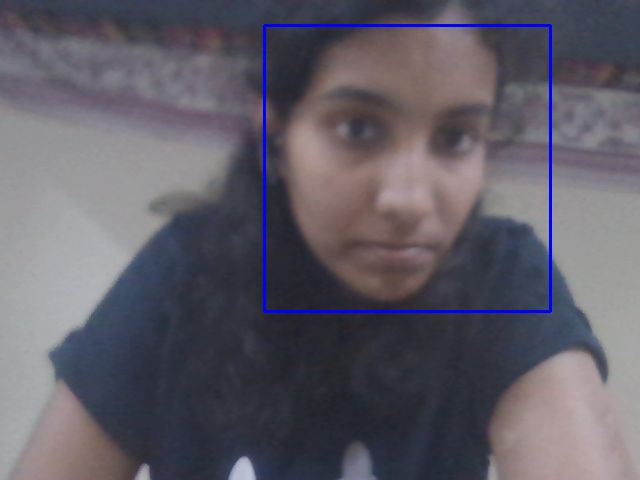

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: white; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

##Face Capturing


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# JavaScript to create the video stream using the webcam
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
           stream.getVideoTracks()[0].stop();
           video.remove();
           div.remove();
           video = null;
           div = null;
           stream = null;
           imgElement = null;
           captureCanvas = null;
           labelElement = null;
        }

        function onAnimationFrame() {
          if (!shutdown) {
            window.requestAnimationFrame(onAnimationFrame);
          }
          if (pendingResolve) {
            var result = "";
            if (!shutdown) {
              captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
              result = captureCanvas.toDataURL('image/jpeg', 0.8)
            }
            var lp = pendingResolve;
            pendingResolve = null;
            lp(result);
          }
        }

        async function createDom() {
          if (div !== null) {
            return stream;
          }

          div = document.createElement('div');
          div.style.border = '2px solid black';
          div.style.padding = '3px';
          div.style.width = '100%';
          div.style.maxWidth = '600px';
          document.body.appendChild(div);

          const modelOut = document.createElement('div');
          modelOut.innerHTML = "<span>Status:</span>";
          labelElement = document.createElement('span');
          labelElement.innerText = 'No data';
          labelElement.style.fontWeight = 'bold';
          modelOut.appendChild(labelElement);
          div.appendChild(modelOut);

          video = document.createElement('video');
          video.style.display = 'block';
          video.width = div.clientWidth - 6;
          video.setAttribute('playsinline', '');
          video.onclick = () => { shutdown = true; };
          stream = await navigator.mediaDevices.getUserMedia(
              {video: { facingMode: "environment"}});
          div.appendChild(video);

          imgElement = document.createElement('img');
          imgElement.style.position = 'absolute';
          imgElement.style.zIndex = 1;
          imgElement.onclick = () => { shutdown = true; };
          div.appendChild(imgElement);

          const instruction = document.createElement('div');
          instruction.innerHTML =
              '<span style="color: white; font-weight: bold;">' +
              'When finished, click here or on the video to stop this demo</span>';
          div.appendChild(instruction);
          instruction.onclick = () => { shutdown = true; };

          video.srcObject = stream;
          await video.play();

          captureCanvas = document.createElement('canvas');
          captureCanvas.width = 640;
          captureCanvas.height = 480;
          window.requestAnimationFrame(onAnimationFrame);

          return stream;
        }
        async function stream_frame(label, imgData) {
          if (shutdown) {
            removeDom();
            shutdown = false;
            return '';
          }

          var preCreate = Date.now();
          stream = await createDom();

          var preShow = Date.now();
          if (label != "") {
            labelElement.innerHTML = label;
          }

          if (imgData != "") {
            var videoRect = video.getClientRects()[0];
            imgElement.style.top = videoRect.top + "px";
            imgElement.style.left = videoRect.left + "px";
            imgElement.style.width = videoRect.width + "px";
            imgElement.style.height = videoRect.height + "px";
            imgElement.src = imgData;
          }

          var preCapture = Date.now();
          var result = await new Promise(function(resolve, reject) {
            pendingResolve = resolve;
          });
          shutdown = false;

          return {'create': preShow - preCreate,
                  'show': preCapture - preShow,
                  'capture': Date.now() - preCapture,
                  'img': result};
        }
        ''')

    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# start streaming video from webcam
video_stream()

# Ask for the person's name to create folder
person_name = input("Enter the person's name: ")
save_path = f"/content/drive/MyDrive/faces/{person_name}"
os.makedirs(save_path, exist_ok=True)  # Create directory if not exists

# label for video
label_html = 'Capturing...'
# initialize bounding box to empty
bbox = ''
count = 0
max_images = 50  # Limit the number of images

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # get face bounding box for overlay and saving images
    for (x, y, w, h) in faces:
        if count < max_images:
            count += 1
            face = img[y:y+h, x:x+w]
            cv2.imwrite(f"{save_path}/{person_name}_{str(count)}.jpg", face)

        # Draw green rectangle around face
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), (0, 255, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

    # Break when 50 images have been saved
    if count >= max_images:
        print(f"Captured {max_images} images. Stopping...")
        break


<IPython.core.display.Javascript object>

Enter the person's name: Kuhu
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Captured 50 images. Stopping...


##Trial Recognition

In [ ]:
!pip install face_recognition

In [ ]:
#Trial code for capturing face and showing name in snaps

# Import dependencies
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import PIL
import io
import os
import tensorflow as tf
from google.colab.patches import cv2_imshow

# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
        js_reply: JavaScript object containing image from webcam
    Returns:
        img: OpenCV BGR image
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load MobileNet model for face recognition
model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True)

# Function to capture images and save to the specified folder
def capture_images(folder_name, num_images=50):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    count = 0
    label_html = 'Capturing...'
    bbox = ''

    while count < num_images:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        img = js_to_image(js_reply["img"])
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray)

        for (x, y, w, h) in faces:
            count += 1
            face = img[y:y + h, x:x + w]
            cv2.imwrite(os.path.join(folder_name, f"{folder_name}.{count}.jpg"), face)
            bbox = ''  # No bounding box during capture

    return count

# Function for face recognition using MobileNet
def recognize_face(image):
    image = cv2.resize(image, (224, 224))  # Resize to match MobileNet input shape
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Preprocess the image
    preds = model.predict(np.expand_dims(image, axis=0))
    return preds

# JavaScript to create our live video stream using our webcam as input
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "environment"}});
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                '<span style="color: white; font-weight: bold;">' +
                'When finished, click here or on the video to stop this demo</span>';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640; //video.videoWidth;
            captureCanvas.height = 480; //video.videoHeight;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label != "") {
                labelElement.innerHTML = label;
            }

            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate,
                    'show': preCapture - preShow,
                    'capture': Date.now() - preCapture,
                    'img': result};
        }
    ''')

    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Start streaming video from webcam
video_stream()

# Example recognition on a new frame (after capturing)
while True:
    js_reply = video_frame("Recognizing...", '')
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    for (x, y, w, h) in faces:
        face_image = img[y:y + h, x:x + w]
        predictions = recognize_face(face_image)

        # For demonstration purposes, we will label the bounding box with "Person"
        label = "Sanjivani"  # Replace this with the recognized person's name based on predictions
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Put label

    cv2_imshow("Recognition", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

# Function to start video stream in the browser
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8);
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def js_to_image(js_reply):
    """Converts the JavaScript frame to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img
from PIL import Image
import io

def bbox_to_bytes(bbox_array):
    """Converts bounding box image array into bytes"""
    bbox_PIL = Image.fromarray(bbox_array)

    # Convert from RGBA to RGB (remove alpha channel)
    if bbox_PIL.mode == 'RGBA':
        bbox_PIL = bbox_PIL.convert('RGB')

    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='jpeg')
    return iobuf.getvalue()


# Start video stream
video_stream()

# Label for video
label_html = 'Capturing...'
bbox = ''
count = 0

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    js_reply = eval_js('stream_frame("{}", "{}")'.format(label_html, bbox))
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Draw rectangle around each face
    for (x, y, w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), (255, 0, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox so the next frame gets the new overlay
    bbox = bbox_bytes


In [ ]:
# Import dependencies
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics.pairwise import cosine_similarity

# Load MobileNetV2 model for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to overlay on video stream
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# Load dataset and compute embeddings
def load_dataset(dataset_path):
    known_embeddings = []
    known_names = []

    for person_name in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person_name)
        if os.path.isdir(person_folder):
            for image_name in os.listdir(person_folder):
                image_path = os.path.join(person_folder, image_name)
                img = cv2.imread(image_path)
                img = cv2.resize(img, (224, 224))
                img = img.astype('float32') / 255.0
                img = np.expand_dims(img, axis=0)
                embedding = model.predict(img)[0]
                known_embeddings.append(embedding)
                known_names.append(person_name)

    return known_embeddings, known_names


dataset_path = '/content/drive/MyDrive/faces'
known_embeddings, known_names = load_dataset(dataset_path)

<ipython-input-4-c42ffb48bdbc>:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1

In [ ]:
# Function to create the video stream
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                {video: { facingMode: "user" }});

            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML =
                '<span style="color: white; font-weight: bold;">' +
                'When finished, click here or on the video to stop this demo</span>';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640;
            captureCanvas.height = 480;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label != "") {
                labelElement.innerHTML = label;
            }

            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {'create': preShow - preCreate,
                    'show': preCapture - preShow,
                    'capture': Date.now() - preCapture,
                    'img': result};
        }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# Start streaming video from webcam
video_stream()

# Label for video
label_html = 'Capturing...'
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # Get face bounding box for overlay
    for (x, y, w, h) in faces:
        # Extract the face from the image
        face_roi = img[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (224, 224))
        face_roi = face_roi.astype('float32') / 255.0
        face_roi = np.expand_dims(face_roi, axis=0)

        # Generate the face embedding
        embedding = model.predict(face_roi)[0]

        # Compare with known embeddings to find the closest match
        if len(known_embeddings) > 0:
            similarities = cosine_similarity([embedding], known_embeddings)[0]
            best_match_index = np.argmax(similarities)
            confidence = similarities[best_match_index]

            # Set a threshold for recognizing a person
            threshold = 0.5  # Adjust this threshold as needed
            if confidence > threshold:
                name = known_names[best_match_index]
                label_html = f'{name}: {confidence:.2f}'
            else:
                label_html = 'Unknown'
        else:
            label_html = 'Unknown'

        # Draw the bounding box and label on the image
        cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(bbox_array, label_html, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Create alpha channel for bbox_array
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
